<a href="https://colab.research.google.com/github/LashawnFofung/RAG-Pipelines/blob/main/src/Task_Advanced_PDF_Retrieval_and_Optimization_with_LlamaIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **🚀 Advanced PDF Retrieval & Optimization with LlamaIndex**

**Data:** *sample_contract.pdf*
<br><br>

This notebook demonstrates enhanced RAG techniques: query expansion hybrid retrieval (keywords + vector), and reranking. The goal is to
significantly boost the quality and relevance of search results from complex PDF documents.
<br><br>

 **Table of Contents**
* [1. Loading PDFs with PyMuPDF & LlamaIndex](#scrollTo=Cx5n9MUuSL08&line=1&uniqifier=1)
* [2. Indexing & Processing PDFs](#scrollTo=oe0vakFfzqwr&line=1&uniqifier=1)
* [3. Implement Query Expansion & Rewriting](#scrollTo=s8uE5slTSScv&line=1&uniqifier=1)
* [4. Implement Hybrid Retrieval (Keyword + Vector Search)](#scrollTo=5hUdh3H73k1E&line=1&uniqifier=1)
* [5. Implement Reranking for More Accurate Results](#scrollTo=vuyy5PAb33GK&line=1&uniqifier=1)
* [6. Complete End-to-End Example: Building An Advanced RAG Pipeline](#scrollTo=C9V9Rux54Gka&line=1&uniqifier=1)
* [7. Why This Approach Works Well](#scrollTo=l8wzFTqdYwEL&line=1&uniqifier=1)
* [8. Conclusion](#scrollTo=LgFM6C82ZhTE&line=1&uniqifier=1)



# **1. Loading PDFs with PyMuPDF & LlamaIndex**

### 🌎 Real-World Data Challenge:

This section highlights a critical step: robust document ingestion. **PDFs** are the standard in business and research.  **PyMuPDF** is key here, as it handles the complexities (layout, images, tables) of PDFs far better than simple loaders, ensuring the **LlamaIndex** pipeline starts with clean, structured data.
<br><br>

**Section 1 Table of Contents:**
* [Installation](#scrollTo=OsQP1OvtaRd6&line=1&uniqifier=1)
* [Setup Environment](#scrollTo=q72x0ZmybXTa&line=1&uniqifier=1)
* [Loading and Exploring PDF Documents](#scrollTo=VWdkuLWveejH&line=1&uniqifier=1)
* [Upload a PDF](#scrollTo=4P_fYW80nVVF&line=1&uniqifier=1)
* [Text Extraction Using PyMuPDF](#scrollTo=tRLHXXybqYRa&line=1&uniqifier=1)
* [Testing the PyMuPDF Extraction and Output Preview](#scrollTo=9Je3yFJDrD0O&line=1&uniqifier=1)
* [Integrating PyMuPDF with LlamaIndex](#scrollTo=T3vbgJtduDC-&line=1&uniqifier=1)
* [Example: Converting PDF Pages to LlamaIndex Documents](#scrollTo=DDFJ6iADurXj&line=1&uniqifier=1)

**Installation**

In [1]:
# Install required libraries for the RAG framework and Gemini for the LLM connection
!pip install -q llama-index llama-index-llms-gemini pymupdf
!pip install -q llama-index-embeddings-huggingface
!pip install nest_asyncio

**Setup Environment**

In [2]:
# Setup environment imports
import os
import fitz # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import nest_asyncio


# Fixes conflicts with the existing event loop in Colab/Jupyter,
# allowing asynchronous functions (e.g., in LlamaIndex) to run properly.
nest_asyncio.apply()



# Setup Gemini API Key
import os
from google.colab import userdata

# IMPORTANT: This retrieves the secret named 'GEMINI_API_KEY' from your Colab Secrets
# and sets it as the environment variable 'GOOGLE_API_KEY', which is the official name
# required by the underlying Google SDK.

try:
    API_KEY = userdata.get('GEMINI_API_KEY')

    if API_KEY is None:
        raise ValueError("Key not found in Colab Secrets.")

    # Set the official environment variable name required by the Google GenAI SDK
    os.environ["GOOGLE_API_KEY"] = API_KEY

    # Validation Check: Ensure the environment variable is actually set
    if os.environ.get("GOOGLE_API_KEY") is not None and len(os.environ.get("GOOGLE_API_KEY")) > 10:
        print("✅ API Key successfully loaded from Colab Secrets and set as GOOGLE_API_KEY.")

    else:
            raise ValueError("Key retrieved but failed validation.")

except ValueError as e:
    print(f"❌ FATAL ERROR: {e}")
    print("\n--- TROUBLESHOOTING ---")
    print("1. **Secret Name Check:** Ensure the name in your Colab Secrets panel is **exactly** `GEMINI_API_KEY`.")
    print("2. **Notebook Access Check:** Ensure the toggle switch next to `GEMINI_API_KEY` in the Secrets panel is **ON**.")
    print("3. **Key Validity:** Double-check that the key you pasted into the Value field is correct and has not been revoked.")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")
    print("Please try restarting the runtime.")



# Create a directory for our PDFs if it doesn't exist
!mkdir -p sample_docs

✅ API Key successfully loaded from Colab Secrets and set as GOOGLE_API_KEY.


**Loading and Exploring PDF Documents**

In [3]:
#Load and extracttext from a PDF using PyMuPDF
from google.colab import files
import os

def upload_pdf():
  """Upload a PDF file and return its path."""
  print("Please select a PDF file to upload:")
  uploaded = files.upload()

  for filename in uploaded.keys():
    if filename.endswith('.pdf'):
      # Save to the sample_docs directory
      pdf_path = os.path.join('sample_docs', filename)

      # Create directory if it doesn't exist
      os.makedirs("sample_docs", exist_ok=True)

      # Save the uploaded file to the sample_docs directory
      with open(pdf_path, 'wb') as f:
        f.write(uploaded[filename])

      print(f"PDF saved to {pdf_path}")
      return pdf_path
    else:
      print(f"File{filename} is not a PDF. Please upload a PDF file.")
  return None



**Upload a PDF**

In [4]:
 #Upload the sample_contract.pdf file
from google.colab import files
uploaded = files.upload()

# Get the filename from the keys of the uploaded dictionary.
# This assumes the user uploads only one file.
pdf_path = None # Initialize pdf_path
if uploaded:
    pdf_path = list(uploaded.keys())[0]
    print(f"Successfully uploaded: {pdf_path}")
else:
    print("No file was uploaded.")

Saving sample_contract.pdf to sample_contract (2).pdf
Successfully uploaded: sample_contract (2).pdf


**Text Extraction Using PyMuPDF**

In [5]:
# Initializes PyMuPDF to open the document and extracts raw text page-by-page.
# This method is chosen for its efficiency and better handling of PDF structure compared to basic loaders.
# The function also provides basic statistics (pages, word count) for monitoring.

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file using PyMuPDF."""
    doc = fitz.open(pdf_path)

    # Extract text from all pages
    text = "\n".join([page.get_text() for page in doc])

    # Print some stats
    print(f"PDF: {pdf_path}")
    print(f"Number of pages: {len(doc)}")
    print(f"Extracted {len(text.split())} words from the PDF.")

    # Close the document
    doc.close()

    return text

**Testing the PyMuPDF Extraction and Output Preview**

In [6]:
# Example usage (after uploading a PDF):
if pdf_path:
    text = extract_text_from_pdf(pdf_path)
    print("\n--- Extracted Text Preview (First 500 characters) ---")
    print(text[:500])  # Print first 500 characters
else:
    print("Skipping extraction. No PDF file path available.")

PDF: sample_contract (2).pdf
Number of pages: 2
Extracted 315 words from the PDF.

--- Extracted Text Preview (First 500 characters) ---
SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15, 2025 (the "Effective Date")
by and between:
ABC Company Inc., with its principal place of business at 123 Business Avenue, Corporate City, State
12345 ("Service Provider"); and
XYZ Corporation, with its principal place of business at 456 Commerce Street, Enterprise Town, State
67890 ("Client").
1. SERVICES
1.1 Service Provider agrees to provide Client with consulting services ("Services") as des


**Integrating PyMuPDF with LlamaIndex**

In [7]:
# Setup A Custom Loader to Integrate PyMuPDF with LlamaIndex
from llama_index.core import Document
from typing import List

def load_pdf_with_pymupdf(pdf_path: str) -> List[Document]:
    """Load a PDF and convert it to LlamaIndex Document format using PyMuPDF."""
    # Open the PDF
    doc = fitz.open(pdf_path)

    # Extract text from each page
    documents = []

    for i, page in enumerate(doc):
        text = page.get_text()

        # Skip empty pages
        if not text.strip():
            continue

        # Create Document object with metadata
        documents.append(
            Document(
                text=text,
                metadata={
                    "file_name": os.path.basename(pdf_path),
                    "page_number": i + 1,
                    "total_pages": len(doc)
                }
            )
        )

    # Close the document
    doc.close()

    # Print stats
    print(f"Processed {pdf_path}:")
    print(f"Extracted {len(documents)} pages with content")

    return documents



**Example: Converting PDF Pages to LlamaIndex Documents**

We define a custom loader function, `load_pdf_with_pymupdf`, which iterates through the PDF, extracting text from each page. By creating a separate `Document` object for every page and including **metadata**, we lay the foundation for highly granular chunking and retrieval later on.

In [8]:
# Example usage after uploading a PDF:
pdf_docs = load_pdf_with_pymupdf(pdf_path)

Processed sample_contract (2).pdf:
Extracted 2 pages with content


# **2. Indexing & Processing PDFs**

**🔗 Initialize Gemini, Embeddings, and Indexing Logic**

This section initializes the core infrastructure for Retrieval-Augmented Generation (RAG). We set up the **ServiceContext** (which defines the embedding model and chunking strategy) and then create the **VectorStoreIndex** by processing our custom LlamaIndex Documents. This index creation step is where the PDF text is broken down into chunks and embedded.
<br><br>

**Section 2 Table of Contents**
* [RAG Pipeline Setup: LLM, Embeddings, and Indexing Function](#scrollTo=EE5uaKlx__Jr&line=1&uniqifier=1)
* [Index the PDF](#scrollTo=DEYuM4e_AhxV&line=1&uniqifier=1)

**RAG Pipeline Setup: LLM, Embeddings, and Indexing Function**

In [9]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-2.5-flash")
Settings.llm = llm

# Initialize embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
Settings.embed_model = embed_model

def process_and_index_pdf(pdf_path):
    """Process a PDF and create both vector and keyword indices."""
    # Load documents
    documents = load_pdf_with_pymupdf(pdf_path)

    # Create vector index
    vector_index = VectorStoreIndex.from_documents(documents)

    print(f"Indexed {len(documents)} document chunks")

    return vector_index

/tmp/ipython-input-2090996844.py:7: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.5-flash")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Index The PDF**

In [10]:
# Index the PDF
index = process_and_index_pdf(pdf_path)

Processed sample_contract (2).pdf:
Extracted 2 pages with content
Indexed 2 document chunks


# **3. Implement Query Expansion & Rewriting**

✍️ **Maximizing Initial Recall**

Standard keyword or vector search can sometimes miss relevant documents.  **Query Expansion** addresses this by rewriting the initial user query into multiple, semantically similar versions, ensuring a wider range of potentially relevant chunks are retrieved in the next step (higher Recall).
<br><br>

Uses the LLM (Gemini) to generate variations of the user's query. By sending these expanded queries to the index, there is an increase in the likelihood of capturing all relevant document chunks, which is essential before the final reranking stage.
<br><br>

**Section 3 Table of Contents**
* [Defining the Query Expansion Logic](#scrollTo=1fq7lMCQ_3Dk&line=1&uniqifier=1)
* [Example: Usage Implementing Query Expansion & Rewriting](#scrollTo=vXIhNGjfA7Re&line=1&uniqifier=1)
* [Creating a Query Expansion Engine](#scrollTo=tMIZDpB6CJ7E&line=1&uniqifier=1)
* [Example: Creating a Query Expansion Engine](#scrollTo=-v4FOrKxDmAS&line=1&uniqifier=1)
* [Install BM25 Retriever Dependency for Hybrid Search](#scrollTo=F-mnnTrVEXYl)

**Defining the Query Expansion Logic**

In [11]:
from llama_index.llms.gemini import Gemini
from llama_index.core import Settings

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-2.5-flash")
Settings.llm = llm

# Simple query expansion function using Gemini
def expand_query(query: str, num_expansions: int = 3) -> list:
    """Expand a query to include related terms using Gemini."""
    prompt = f"""
    I need to search a legal contract with this query: "{query}"

    Please help me expand this query by generating {num_expansions} alternative versions that:
    1. Use different but related terminology
    2. Include relevant legal terms that might appear in a contract
    3. Cover similar concepts but phrased differently

    Format your response as a list of alternative queries only, with no additional text.
    """

    response = llm.complete(prompt)

    # Extract the expanded queries
    expanded_queries = [line.strip() for line in response.text.split('\n') if line.strip()]

    # Add the original query if needed
    if query not in expanded_queries:
        expanded_queries = [query] + expanded_queries

    return expanded_queries

/tmp/ipython-input-1618107586.py:5: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-2.5-flash")


**Example: Usage Implementing Query Expansion & Rewriting**

In [12]:
# Example usage:
expanded = expand_query("What are the penalties for late payments?")
for i, q in enumerate(expanded):
    print(f"{i+1}. {q}")

1. What are the penalties for late payments?
2. *   What remedies are available for a payment default?
3. *   Are there provisions for late fees, interest, or liquidated damages for overdue amounts?
4. *   What are the consequences of a breach of payment terms?


**Creating a Query Expansion Engine**

In [13]:
# Implement a structured query expansion using LlamaIndex's built-in functionality
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.retrievers import QueryFusionRetriever

# Function to create a query engine that uses query expansion
def create_query_expansion_engine(index):
    """Create a query engine that uses query expansion."""
    # First create multiple retrievers (base retriever)
    base_retriever = index.as_retriever(similarity_top_k=2)

    # Create a query fusion retriever
    fusion_retriever = QueryFusionRetriever(
        retrievers=[base_retriever],
        llm=llm,
        similarity_top_k=2,
        num_queries=3,  # Generate 3 queries per original query
        mode="reciprocal_rerank"  # Use reciprocal rank fusion
    )

    # Create the query engine with the fusion retriever
    query_engine = RetrieverQueryEngine.from_args(
        retriever=fusion_retriever,
        llm=llm,
        verbose=True
    )

    return query_engine


**Example: Creating a Query Expansion Engine**

In [14]:
# Example usage:
expanded_query_engine = create_query_expansion_engine(index)
response = expanded_query_engine.query("What are the penalties for late payments?")
print(response)

Late payments will incur interest at a rate of 1.5% per month, calculated from the due date until the full amount is paid.


**Install BM25 Retriever Dependency for Hybrid Search**

In [15]:
#Install BM25 Dependency
!pip install llama-index-retrievers-bm25

# **4. Implement Hybrid Retrieval (Keyword + Vector Search)**

**🎯 Combining Strengths: Hybrid Search**

Standard vector search can fail on rare terms (poor embedding) and keyword search fails on synonyms. **Hybrid retrieval** mitigates these drawbacks by running both in parallel and merging the results, providing a more robust and comprehensive set of candidates for the final Reranking step.
<br><br>

**Section 4 Table of Contents**
* [Defining the Custom Hybrid Retriever (Vector + BM25)](#scrollTo=rfncwqrmBpUQ&line=1&uniqifier=1)
* [Example: Defining the Custom Hybrid Retriever (Vector + BM25)](#scrollTo=uZ-Kl8oFHSHm&line=1&uniqifier=1)
* [Comparing Retrieval Methods](#scrollTo=bj5-qAF3Np6F&line=1&uniqifier=1)
* [Example: Comparing Retrieval Methods](#scrollTo=Wzu_eZYeO6lG&line=1&uniqifier=1)

**Defining the Custom Hybrid Retriever (Vector + BM25)**

In [16]:
# Defining the Custom Hybrid Retriever (Vector + BM25)
from llama_index.core import VectorStoreIndex
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.schema import NodeWithScore # Import for type hinting/clarity

def create_hybrid_retriever(index, query, vector_top_k=5, keyword_top_k=5, final_limit=10) -> list[NodeWithScore]:
    """
    Creates a hybrid retrieval approach combining vector and keyword search.

    It retrieves top_k from each method, merges the results, removes duplicates,
    and returns a combined list up to final_limit nodes.
    """
    # Method 1: Vector retrieval (semantic search)
    # Uses the index's built-in retriever
    vector_retriever = index.as_retriever(similarity_top_k=vector_top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Method 2: BM25 retrieval (keyword-based search)
    # Get all nodes from the index's docstore for the BM25Retriever to build its corpus
    nodes = [node for node in index.docstore.docs.values()]
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=keyword_top_k
    )
    keyword_nodes = bm25_retriever.retrieve(query)

    # Combine results
    all_nodes = []
    all_nodes.extend(vector_nodes)
    all_nodes.extend(keyword_nodes)

    # Remove duplicates
    unique_nodes = []
    seen_ids = set()
    for node in all_nodes:
        if node.node_id not in seen_ids:
            unique_nodes.append(node)
            seen_ids.add(node.node_id)

    # Sort by score (higher is better).
    # Note: Scores from different retrievers are not directly comparable,
    # but we sort them anyway before reranking.
    sorted_nodes = sorted(unique_nodes,
                          key=lambda x: x.score if hasattr(x, 'score') and x.score is not None else 0.0,
                          reverse=True)

    # Limit to the final desired number of unique candidates
    top_nodes = sorted_nodes[:final_limit]

    return top_nodes

**Example: Defining the Custom Hybrid Retriever (Vector + BM25)**

In [17]:
# Example usage:
# Note: 'top_k=2' changed to 'final_limit=5' for a more useful example.
hybrid_nodes = create_hybrid_retriever(index, "What is the refund policy?", final_limit=5)
print(f"Total unique nodes retrieved: {len(hybrid_nodes)}")
print("-" * 40)

for i, node in enumerate(hybrid_nodes):
    # The score here is from the original retriever (vector or bm25), which
    # is why reranking is the necessary next step!
    print(f"Result {i+1} (Original Score: {node.score:.4f}):")
    print(node.get_text()[:200] + "...") # Print a snippet
    print("-" * 40)

DEBUG:bm25s:Building index from IDs objects


Total unique nodes retrieved: 2
----------------------------------------
Result 1 (Original Score: 0.3974):
4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibit A.
5. CONFIDENTIALITY
5.1 Each party acknowledges that it may receive confidential information fro...
----------------------------------------
Result 2 (Original Score: 0.2141):
SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15, 2025 (the "Effective Date")
by and between:
ABC Company Inc., with its principal place of business...
----------------------------------------


**Comparing Retrieval Methods**

In [18]:
# Create a Function to Compare Different Retrieval Methods
def compare_retrieval_methods(index, query, top_k=2):
    """Compare different retrieval methods for the same query."""
    # Vector retrieval
    vector_retriever = index.as_retriever(similarity_top_k=top_k)
    vector_nodes = vector_retriever.retrieve(query)

    # Keyword retrieval (BM25)
    nodes = [node for node in index.docstore.docs.values()]
    keyword_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=top_k
    )
    keyword_nodes = keyword_retriever.retrieve(query)

    # Hybrid retrieval
    hybrid_nodes = create_hybrid_retriever(index, query, top_k)

    # Create a comparison dataframe
    results = []

    for method, nodes in [
        ("Vector (Semantic)", vector_nodes),
        ("Keyword (BM25)", keyword_nodes),
        ("Hybrid", hybrid_nodes)
    ]:
        for i, node in enumerate(nodes):
            results.append({
                "Method": method,
                "Rank": i + 1,
                "Score": node.score if hasattr(node, 'score') else 0.0,
                "Content": node.get_text()[:200] + "...",  # First 200 chars
                "Page": node.metadata.get("page_number", "Unknown") if hasattr(node, 'metadata') else "Unknown"
            })

    results_df = pd.DataFrame(results)
    display(results_df)

    # Visualize scores
    plt.figure(figsize=(10, 6))
    for method in ["Vector (Semantic)", "Keyword (BM25)", "Hybrid"]:
        method_df = results_df[results_df["Method"] == method]
        plt.bar(
            [f"{method} - Rank {row['Rank']}" for _, row in method_df.iterrows()],
            method_df["Score"],
            alpha=0.7,
            label=method
        )

    plt.xlabel("Result")
    plt.ylabel("Retrieval Score")
    plt.title(f"Comparison of Retrieval Methods for Query: '{query}'")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

**Example: Comparison of Retrieval Methods**

DEBUG:bm25s:Building index from IDs objects
DEBUG:bm25s:Building index from IDs objects


,Method,Rank,Score,Content,Page
0,Vector (Semantic),1,0.397415,4.3 No refunds will be issued for completed pr...,2
1,Vector (Semantic),2,0.214101,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
2,Keyword (BM25),1,0.322329,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
3,Keyword (BM25),2,0.100949,4.3 No refunds will be issued for completed pr...,2
4,Hybrid,1,0.397415,4.3 No refunds will be issued for completed pr...,2
5,Hybrid,2,0.214101,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1


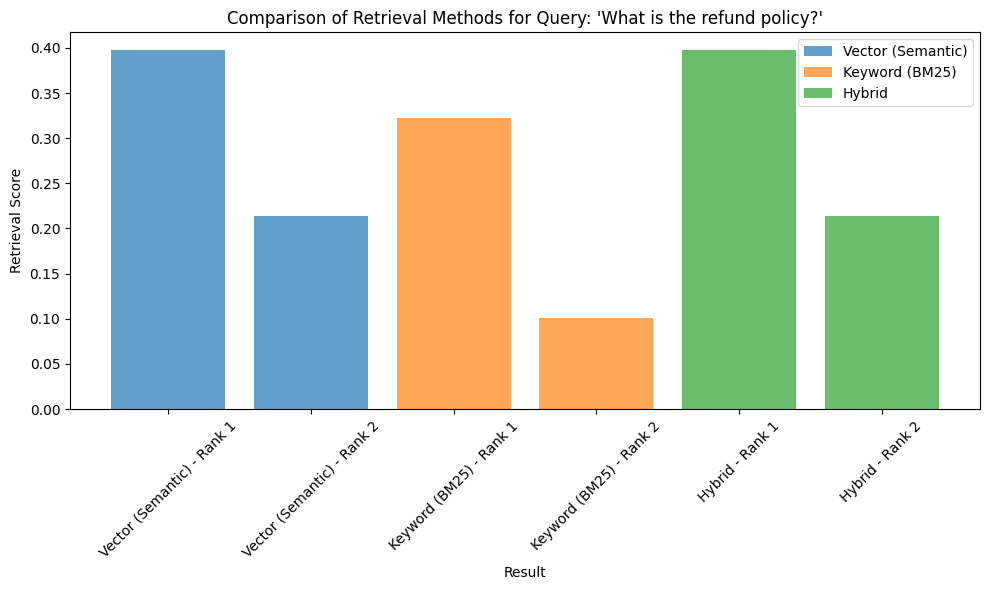

In [19]:
# Example usage:
comparison = compare_retrieval_methods(index, "What is the refund policy?")

# **5. Implement Reranking for More Accurate Results**

**📏 Final Optimization: Reranking the Candidate List**

The previous hybrid retrieval step maximized **Recall** (finding all possible candidates). This section focuses on maximizing **Precision**. We use a specialized, high-performance model (e.g., Cross-Encoder) to re-score the combined set of retrieved nodes, filtering out irrelevant chunks and ensuring the final, top results are truly the most accurate.
<br><br>

**Section 5 Table of Contents**
* [Defining and Demonstrating SentenceTransformer Ranking](#scrollTo=GUE078GcTgDE&line=1&uniqifier=1)
* [Example: Demonstrate Reranking](#scrollTo=czP-dY2_TWWz&line=1&uniqifier=1)

**Defining and Demonstrating SentenceTransformer Reranking**

In [21]:
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.core.schema import NodeWithScore

# Create a reranker
def rerank_results(nodes, query, top_n=2):
    """Rerank retrieved nodes using the Sentence Transformer reranker."""
    # Create the reranker
    reranker = SentenceTransformerRerank(
        model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        top_n=top_n
    )

    # Rerank the nodes
    reranked_nodes = reranker.postprocess_nodes(
        nodes,
        query_str=query
    )

    return reranked_nodes

# Function to demonstrate the reranking process
def demonstrate_reranking(index, query, top_k=4):
    """Demonstrate the reranking process on retrieval results."""
    # First retrieve more nodes than we need
    retriever = index.as_retriever(similarity_top_k=top_k)
    nodes = retriever.retrieve(query)

    print(f"Query: {query}")
    print("\nOriginal Retrieval Order:")
    for i, node in enumerate(nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Now rerank them
    reranked_nodes = rerank_results(nodes, query, top_n=2)

    print("\nAfter Reranking:")
    for i, node in enumerate(reranked_nodes):
        print(f"{i+1}. (Score: {node.score:.4f}) - {node.get_text()[:100]}...")

    # Create comparison dataframe
    results = []

    # Original ranking
    for i, node in enumerate(nodes):
        results.append({
            "Stage": "Original Retrieval",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    # Reranked
    for i, node in enumerate(reranked_nodes):
        results.append({
            "Stage": "After Reranking",
            "Rank": i + 1,
            "Score": node.score,
            "Content": node.get_text()[:150] + "...",
            "Page": node.metadata.get("page_number", "Unknown")
        })

    results_df = pd.DataFrame(results)
    display(results_df)

**Example: Demonstrate Reranking**

In [22]:
# Example usage:
reranking_demo = demonstrate_reranking(index, "What happens if I cancel the service?", top_k=4)

Query: What happens if I cancel the service?

Original Retrieval Order:
1. (Score: 0.2613) - SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15...
2. (Score: 0.1527) - 4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibi...


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]


After Reranking:
1. (Score: -8.3015) - SERVICE AGREEMENT CONTRACT
This Service Agreement (the "Agreement") is entered into as of January 15...
2. (Score: -11.1261) - 4.3 No refunds will be issued for completed projects that meet the specifications outlined in Exhibi...


,Stage,Rank,Score,Content,Page
0,Original Retrieval,1,-8.301486,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
1,Original Retrieval,2,-11.126129,4.3 No refunds will be issued for completed pr...,2
2,After Reranking,1,-8.301486,SERVICE AGREEMENT CONTRACT\nThis Service Agree...,1
3,After Reranking,2,-11.126129,4.3 No refunds will be issued for completed pr...,2


# **6. Complete End-to-End Example: Building An Advanced RAG Pipeline**

This section represents the culmination of all previous steps. We integrate:
  - 1. **Query Expansion** (generating multiple queries)
  - 2. **Hybrid Retrieval** (using Vector and BM25 search)
  - 3. **Reranking** (using a Cross-Encoder model)to form a single, highly optimized **advanced RAG pipeline**.
  
The goal is to demonstrate how these stacked optimizations work together to deliver significantly more accurate and trustworthy answers from complex PDF documents.
<br><br>

**Section 6 Table of Contents**
* [Assembling the Advanced Hybrid RAG Pipeline](#scrollTo=OzYfiKzQVQMK&line=1&uniqifier=1)
* [Example: End-to-End Test and Results Generation](#scrollTo=0OdfMchDXLI2&line=1&uniqifier=1)

**Assembling the Advanced Hybrid RAG Pipeline**

In [23]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SentenceTransformerRerank
from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever
from llama_index.core.schema import NodeWithScore, QueryBundle

def build_rag_pipeline(index):
    """Build a simple but effective RAG pipeline with hybrid retrieval and reranking."""

    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())

    # Determine safe top_k value (number of nodes to retrieve)
    # Must be at least 1 and no more than the number of available nodes
    num_nodes = len(nodes)
    safe_top_k = min(2, max(1, num_nodes))

    print(f"Index contains {num_nodes} nodes, using top_k={safe_top_k}")

    # Step 1: Create a hybrid retriever combining vector and keyword search
    # First, get the vector retriever (for semantic understanding)
    vector_retriever = index.as_retriever(
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Next, create a BM25 retriever (for keyword matching)
    # Get all nodes from the index's docstore
    nodes = list(index.docstore.docs.values())
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=safe_top_k  # Retrieve top 3 most similar chunks
    )

    # Create a proper hybrid retriever class
    class HybridRetriever(BaseRetriever):
        """Hybrid retriever that combines vector and keyword search results."""

        def __init__(self, vector_retriever, keyword_retriever, top_k=2):
            """Initialize with vector and keyword retrievers."""
            self.vector_retriever = vector_retriever
            self.keyword_retriever = keyword_retriever
            self.top_k = top_k
            super().__init__()

        def _retrieve(self, query_bundle, **kwargs):
            """Retrieve from both retrievers and combine results."""
            # Get results from both retrievers
            vector_nodes = self.vector_retriever.retrieve(query_bundle)
            keyword_nodes = self.keyword_retriever.retrieve(query_bundle)

            # Combine all nodes
            all_nodes = list(vector_nodes) + list(keyword_nodes)

            # Remove duplicates (by node_id)
            unique_nodes = {}
            for node in all_nodes:
                if node.node_id not in unique_nodes:
                    unique_nodes[node.node_id] = node

            # Sort by score (higher is better)
            sorted_nodes = sorted(
                unique_nodes.values(),
                key=lambda x: x.score if hasattr(x, 'score') else 0.0,
                reverse=True
            )

            return sorted_nodes[:self.top_k]  # Return top results

    # Create our hybrid retriever instance
    hybrid_retriever = HybridRetriever(
        vector_retriever=vector_retriever,
        keyword_retriever=bm25_retriever,
        top_k=safe_top_k
    )

    # Step 2: Create a reranker to prioritize the most relevant chunks
    if num_nodes > 1:
        reranker = SentenceTransformerRerank(
            model="cross-encoder/ms-marco-MiniLM-L-6-v2",
            top_n=min(2, num_nodes)  # Keep only top results after reranking
        )
        node_postprocessors = [reranker]
    else:
        node_postprocessors = []


    # Step 3: Build the query engine
    query_engine = RetrieverQueryEngine.from_args(
        retriever=hybrid_retriever,
        llm=llm,
        node_postprocessors=[reranker]
    )

    return query_engine

**Example: End-to-End Test and Result Generation**

In [24]:
# Example usage:
#pdf_path = upload_pdf()
index = process_and_index_pdf(pdf_path)
rag_engine = build_rag_pipeline(index)
response = rag_engine.query("What are the penalties for late payments?")
print('\nFinal Response:\n ---------------------- \n')
print(response)

Processed sample_contract (2).pdf:
Extracted 2 pages with content


DEBUG:bm25s:Building index from IDs objects


Indexed 2 document chunks
Index contains 2 nodes, using top_k=2

Final Response:
 ---------------------- 

Late payments will incur interest at a rate of 1.5% per month, calculated from the due date until the full amount is paid.


# **7. Why This Approach Works Well**

1. **Hybrid Retrieval**: By combining vector search (semantic understanding) with BM25 (keyword matching), we get the best of both worlds:
   - Vector search finds semantically related content even if keywords don't match
   - BM25 ensures we don't miss exact term matches that might be relevant

2. **Reranking**: The SentenceTransformer reranker provides a second opinion on relevance:
   - It uses a specialized cross-encoder model to score query-chunk pairs
   - This helps filter out chunks that might be tangentially related but not directly relevant
   - Results in higher precision answers with less noise

3. **Simplicity**: This approach avoids complex routing logic while still delivering high-quality results:
   - No need for multiple specialized retrievers with complex selection logic
   - Handles most query types well without additional complexity
   - Easier to maintain and understand

This pipeline will retrieve relevant information from PDFs and generate concise, accurate responses using Gemini's capabilities.

# **8. Conclusion**

In this notebook, we explored advanced PDF retrieval techniques with LlamaIndex:

1. Loading and processing PDFs using PyMuPDF
2. Implementing query expansion to improve retrieval quality
3. Using hybrid retrieval to combine semantic and keyword search
4. Applying reranking to prioritize the most relevant results
5. Building an advanced RAG pipeline that combines all these techniques

These techniques can significantly improve the quality of information retrieval from PDFs and other document types in real-world applications.